# Protein Subcellular Location Classification Project

This notebook outlines the end-to-end process for classifying protein subcellular locations using sequence features and machine learning models, following the three-week timeline.

Dataset: deeploc_data.fasta (already uploaded to your Colab environment).
Target Models: Random Forest (RF), Support Vector Machine (SVM), Multilayer Perceptron (MLP).
Feature: Amino Acid Composition (AAC).

## WEEK 1:  Data Preparation and Exploratory Analysis

#1.1 Setup and File Loading

First, we install necessary libraries and import the core packages.

In [ ]:
!pip install biopython

In [ ]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

In [ ]:
# Set plotting style
sns.set_theme(style="whitegrid")
print("Libraries loaded successfully.")

# Define the uploaded FASTA file name
fasta_file = 'deeploc_data.fasta'

Libraries loaded successfully.


#1.2 FASTA Parsing and CSV Conversion
We parse the FASTA file, extract the protein ID, the target label (subcellular location), and the sequence itself.

In [ ]:
data = []
try:
    for record in SeqIO.parse(fasta_file, "fasta"):
        # The ID line format is assumed to be: >ID Location-Sublocation
        # We extract the main location as the label.
        header_parts = record.description.split()
        if len(header_parts) > 1:
            # E.g., 'Cell.membrane-M' -> 'Cell.membrane'
            location_label = header_parts[1].split('-')[0]
        else:
            # Fallback in case of unexpected format
            location_label = "Unknown"

        data.append({
            'ID': record.id,
            'Location': location_label,
            'Sequence': str(record.seq)
        })

    df = pd.DataFrame(data)
    print(f"Dataset successfully parsed. Total records: {len(df)}")
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())

except FileNotFoundError:
    print(f"Error: The file '{fasta_file}' was not found. Please ensure it is uploaded.")
    df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred during parsing: {e}")
    df = pd.DataFrame()

Dataset successfully parsed. Total records: 14004

First 5 rows of the DataFrame:
       ID       Location                                           Sequence
0  Q9H400  Cell.membrane  MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...
1  Q5I0E9  Cell.membrane  MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...
2  P63033  Cell.membrane  MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...
3  Q9NR71  Cell.membrane  MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...
4  Q86XT9  Cell.membrane  MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...


# 1.3 Exploratory Data Analysis (EDA)
We analyze the distribution of the target variable and the length of the protein sequences.

/tmp/ipython-input-3329539517.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette="viridis")


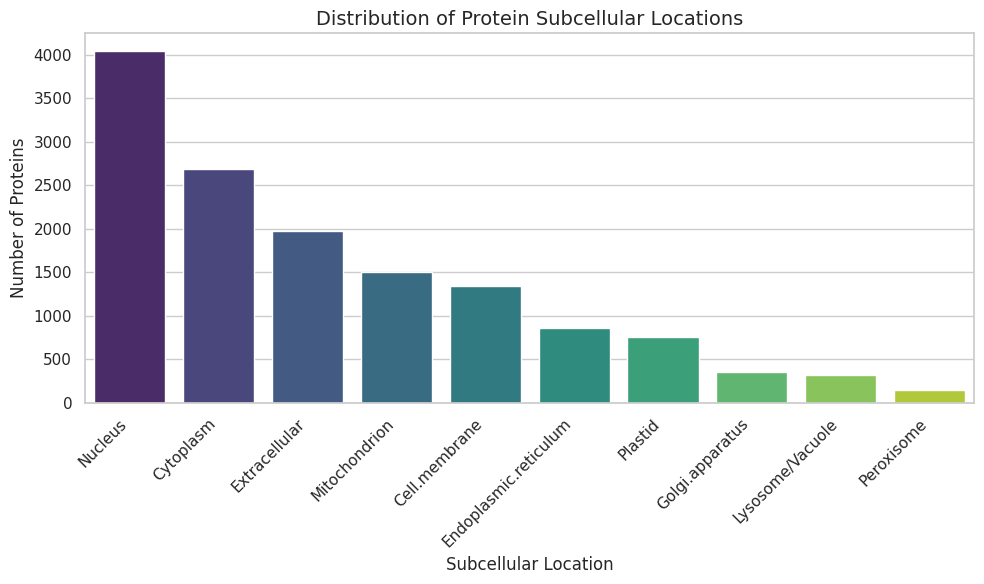

In [ ]:
if not df.empty:
    # --- A. Location Distribution ---
    plt.figure(figsize=(10, 6))
    location_counts = df['Location'].value_counts()
    sns.barplot(x=location_counts.index, y=location_counts.values, palette="viridis")
    plt.title('Distribution of Protein Subcellular Locations', fontsize=14)
    plt.xlabel('Subcellular Location', fontsize=12)
    plt.ylabel('Number of Proteins', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**--- B. Sequence Length Distribution ---**

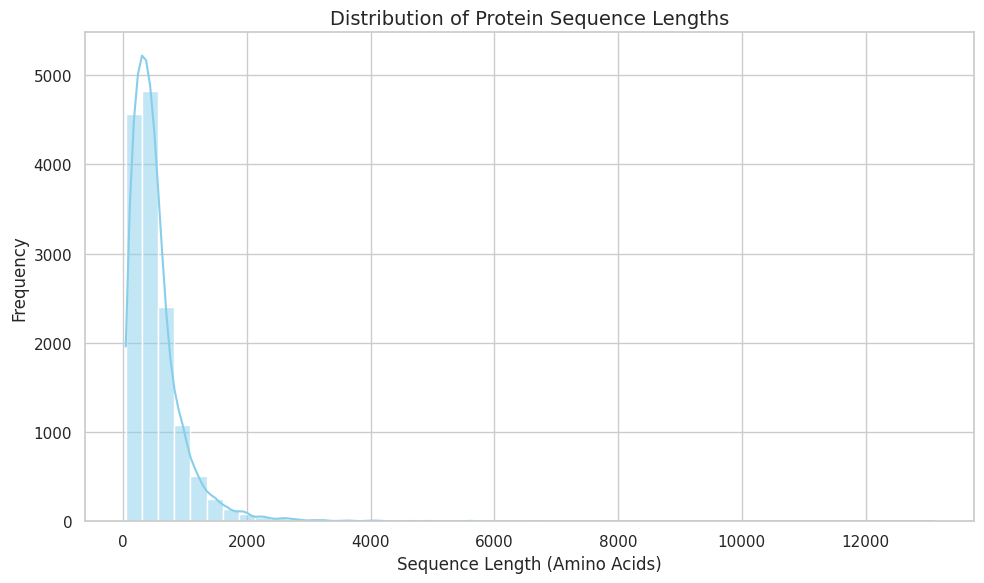

In [ ]:
    df['Sequence_Length'] = df['Sequence'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Sequence_Length'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Protein Sequence Lengths', fontsize=14)
    plt.xlabel('Sequence Length (Amino Acids)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

**Summary statistics**

In [ ]:
    print("\nSummary Statistics of Sequence Lengths:")
    print(df['Sequence_Length'].describe())


Summary Statistics of Sequence Lengths:
count    14004.00000
mean       522.44166
std        448.06671
min         40.00000
25%        249.00000
50%        421.00000
75%        649.00000
max      13100.00000
Name: Sequence_Length, dtype: float64


**Drop the temporary length column**

In [ ]:
    df.drop('Sequence_Length', axis=1, inplace=True)

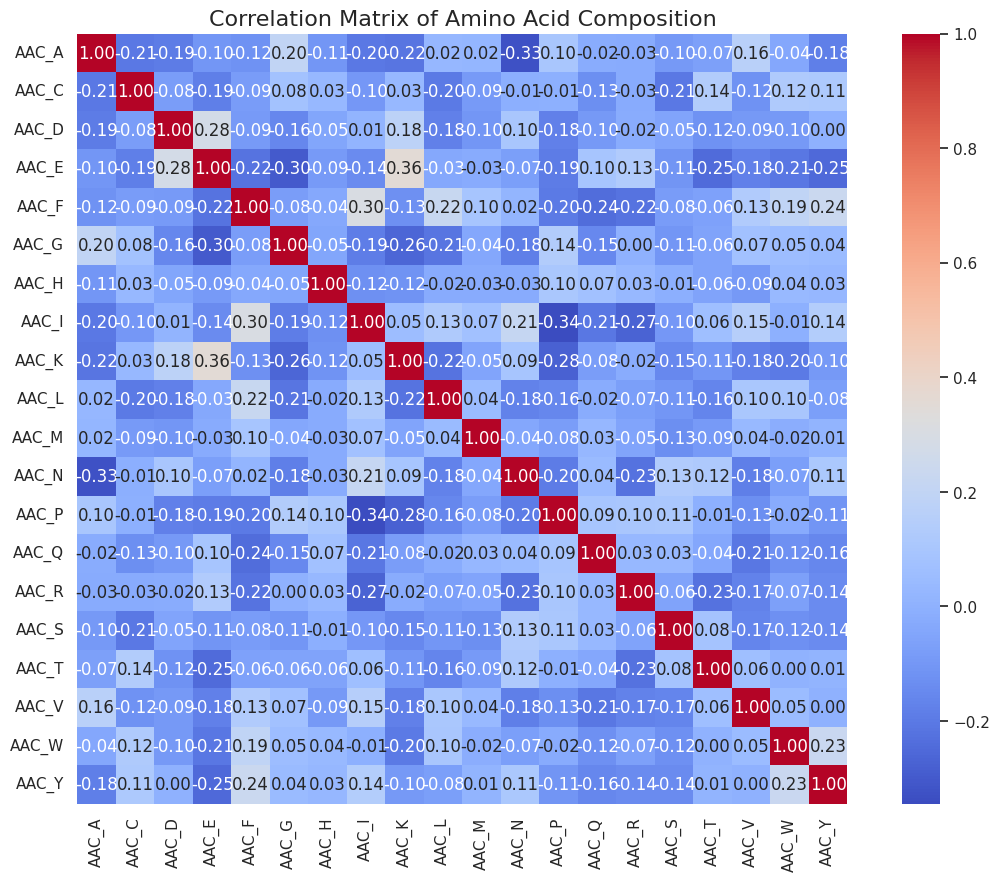

In [ ]:
# Combine AAC features with the target for visualization
eda_df = pd.concat([aac_features, df['Location']], axis=1)

# Compute correlation matrix
corr_matrix = aac_features.corr()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Amino Acid Composition', fontsize=16)
plt.show()

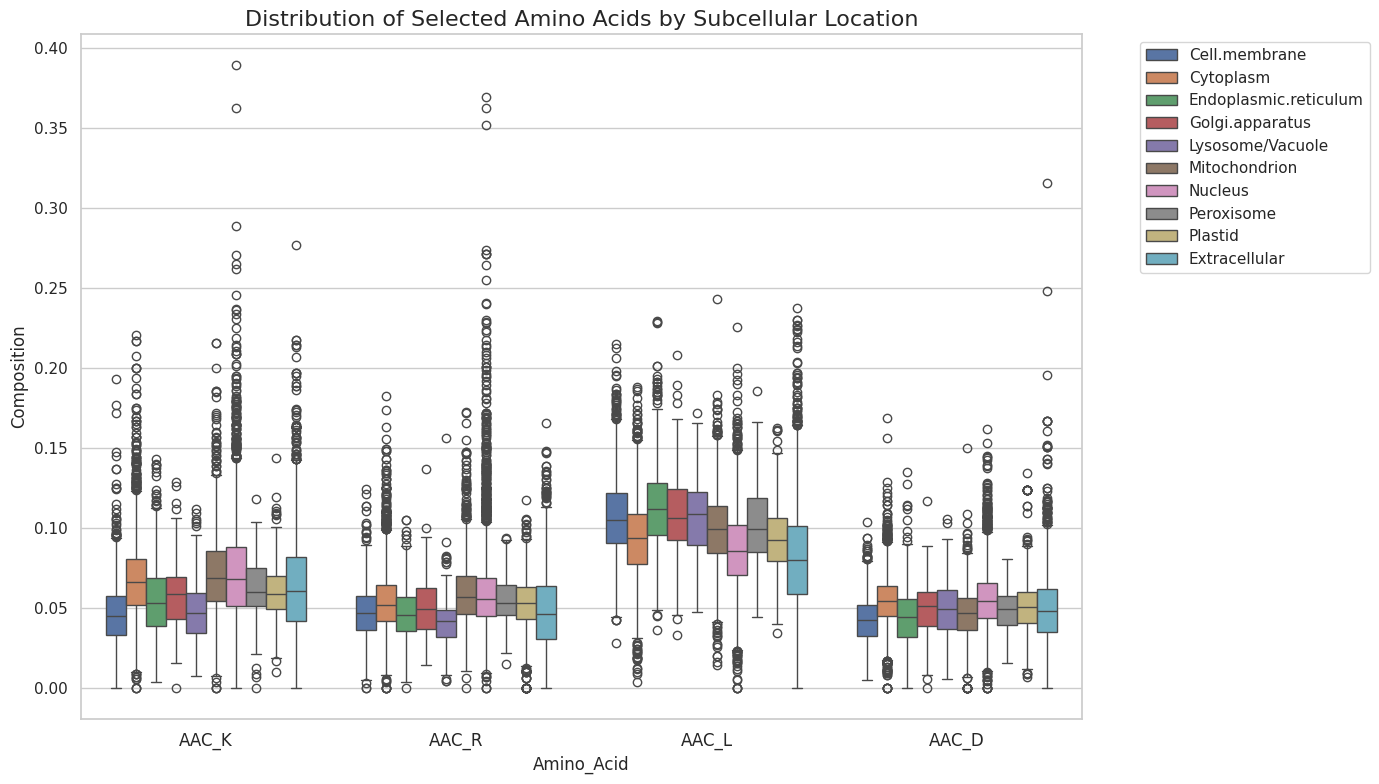

In [ ]:
# List of specific amino acids to check (e.g., K and R are often nuclear signals, L is hydrophobic)
target_aas = ['AAC_K', 'AAC_R', 'AAC_L', 'AAC_D']

# Melt the dataframe for plotting with seaborn
melted_df = eda_df.melt(id_vars='Location', value_vars=target_aas,
                        var_name='Amino_Acid', value_name='Composition')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Amino_Acid', y='Composition', hue='Location', data=melted_df)
plt.title('Distribution of Selected Amino Acids by Subcellular Location', fontsize=16)
plt.xticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

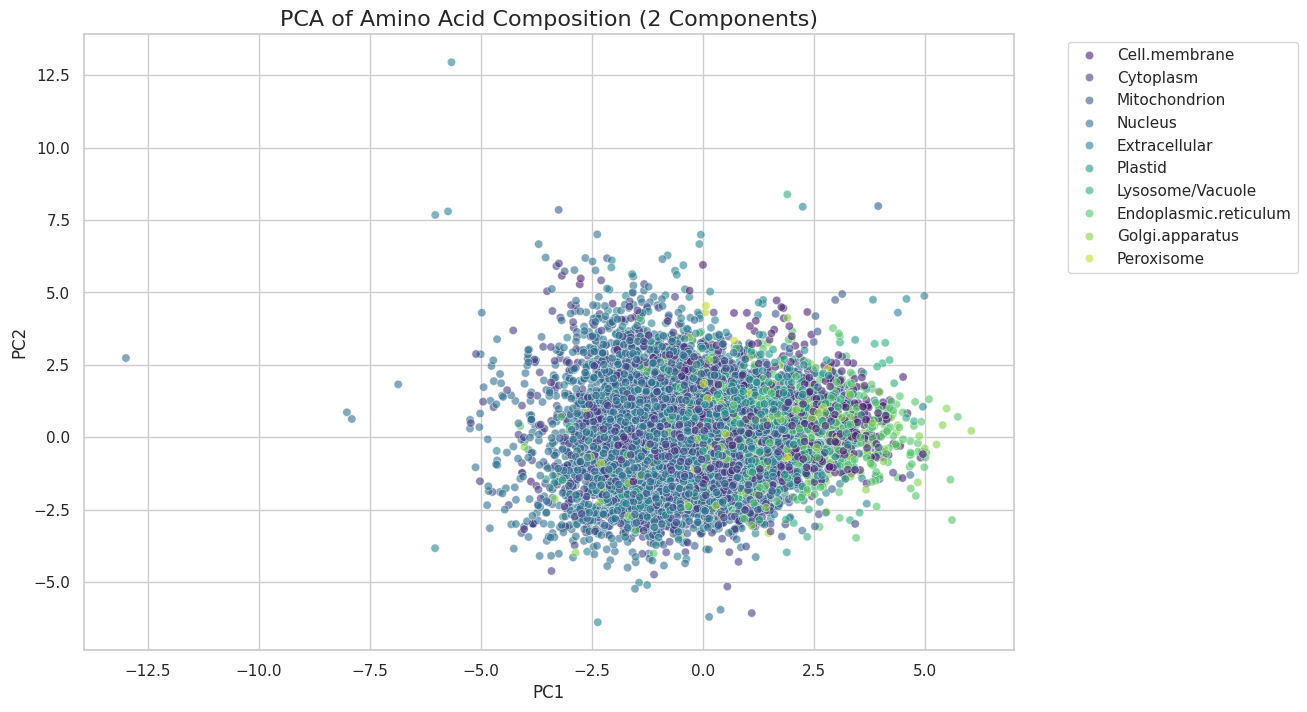

Explained Variance Ratio: [0.12059097 0.11532962]


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled) # Use the scaled training data

# Create a temporary dataframe for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Location'] = le.inverse_transform(y_train) # Decode labels for the legend

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Location', data=pca_df, alpha=0.6, palette='viridis')
plt.title('PCA of Amino Acid Composition (2 Components)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

/tmp/ipython-input-2776496995.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Location', y='Hydrophobicity', data=df, palette='coolwarm')


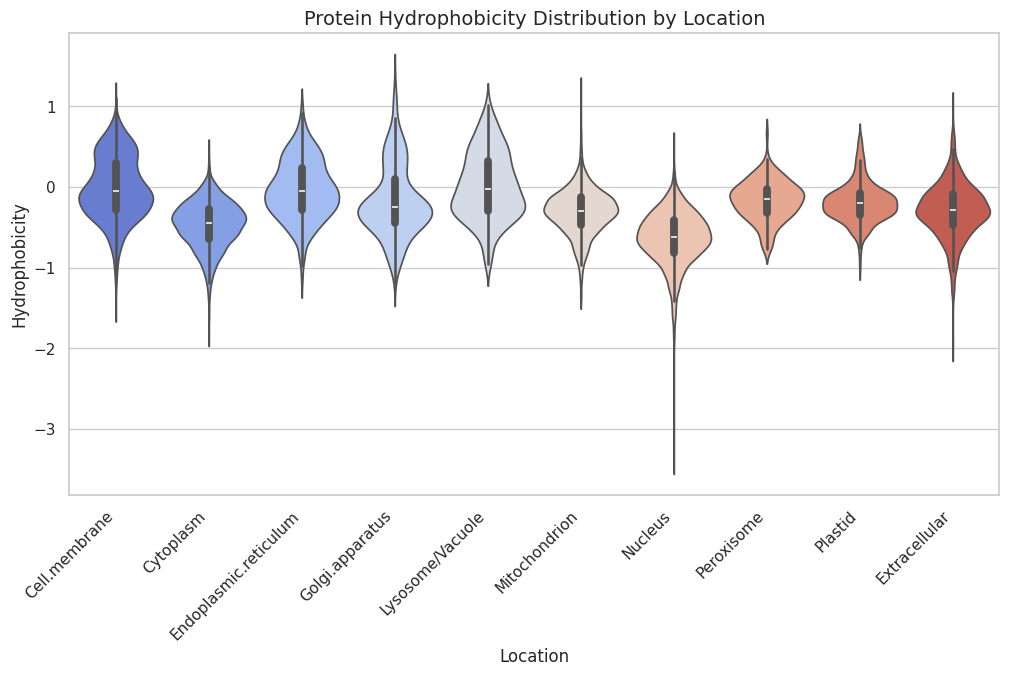

In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def get_physiochemical_props(seq):
    # Biopython requires clean sequences (no unknown 'X' or 'U')
    clean_seq = seq.replace('X', 'A').replace('U', 'A').replace('B', 'D').replace('Z', 'E')
    analysed_seq = ProteinAnalysis(clean_seq)
    try:
        # Calculate Isoelectric Point and Aromaticity
        pi = analysed_seq.isoelectric_point()
        aromaticity = analysed_seq.aromaticity()
        # Gravy is a measure of hydrophobicity
        gravy = analysed_seq.gravy()
        return pd.Series([pi, aromaticity, gravy])
    except:
        return pd.Series([0, 0, 0])

# Create new features
df[['pI', 'Aromaticity', 'Hydrophobicity']] = df['Sequence'].apply(get_physiochemical_props)

# Plot Hydrophobicity by Location
plt.figure(figsize=(12, 6))
sns.violinplot(x='Location', y='Hydrophobicity', data=df, palette='coolwarm')
plt.title('Protein Hydrophobicity Distribution by Location', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()